#Yelp Database Analysis: Capstone Project for the Data Incubator
###December 2015 - February 2016

Description of dataset: http://www.yelp.com/dataset_challenge<br>
Location of dataset: https://www.yelp.com/dataset_challenge/dataset 

Brief description of dataset<br>
Yelp reviews in four countries (10 cities)<br>
1.6M reviews and 500K tips by 366K users for 61K businesses<br>
481K business attributes, e.g., hours, parking availability, ambience.<br>
Social network of 366K users for a total of 2.9M social edges.v
Aggregated check-ins over time for each of the 61K businesses

Cities:<br>
U.K.: Edinburgh<br>
Germany: Karlsruhe<br>
Canada: Montreal and Waterloo<br>
U.S.: Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison<br>

Questions to address:<br>
- What are the seasonal influences on ratings?
- How much influence do fake ratings skew results?
- How influential are previous ratings? Are the most recent reviews more influential?

###Can a restaurant rating be made more accurate?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
mpl.rcParams['savefig.dpi'] = 2 * mpl.rcParams['savefig.dpi']

In [2]:
# This function takes a pandas DataFrame and artifically adjusts the date column.
# The default column name is 'date'. The type of date adjustment is defaulted to
# no change, the user must select year, month or week.
#     year: set all years to 2000 (a leap year)
#     month: set all days to 01 (overrides week)
#     week: set days to either 01, 08, 15 or 22
# The date is expected as a string in the form YYYY-MM-DD
# The function returns the input DataFrame but with the date column adjusted
# and stored as a datetime object

def adjust_date(df, date_col='date', year=False, month=False, week=False):
    if year: df[date_col] = df[date_col].map(lambda x: x.replace(x[:4], '2000'))
    if month: df[date_col] = df[date_col].map(lambda x: x.replace(x[8:], '01'))
    if week:
        i = 0
        for d in df[date_col]:
            if int(d[8:]) < 8: new_day = '01'
            elif int(d[8:]) < 15: new_day = '08'
            elif int(d[8:]) < 22: new_day = '15'
            else: new_day = '22'
            df.at[i,date_col] = d.replace(d[8:], new_day)
            i = i + 1
    # Convert 'date' column from strings to a datetimes
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d')
    return df;

In [3]:
business_datafile = '~/capstone/data/yelp_academic_dataset_business.csv'
biz_id = 16  # Column containing the business_id, variable used as dataframe index name
user_datafile = '~/capstone/data/yelp_academic_dataset_user.csv'
usr_id = 16  # Column containing the user_id, variable used as dataframe index name
review_datafile = '~/capstone/data/yelp_academic_dataset_review.csv'
rev_id = 1   # Column containing the review_id, variable used as dataframe index name

business = pd.read_csv(business_datafile, index_col=biz_id, engine='c')
user = pd.read_csv(user_datafile, index_col=usr_id, engine='c')
review = pd.read_csv(review_datafile, index_col=rev_id, engine='c')

/opt/conda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,4,7,14,18,21,27,30,43,49,52,62,64,66,70,84,89,92,100) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


Example: Get a specific cell by referencing its index

In [4]:
business.categories.ix['KayYbHCt-RkbGcPdGOThNg']

"['Bars', 'American (Traditional)', 'Nightlife', 'Restaurants']"

Create a new dataframe which just holds those buildings which are categorized as 'Restaurants'

In [5]:
rest_crit = business['categories'].map(lambda x: 'Restaurants' in x)
restaurants = business[rest_crit]
restaurant_ids = restaurants.index.values

Get the reviews that correspond to restaurants (as found in the business dataframe).

In [6]:
rest_reviews = review[review['business_id'].isin(restaurant_ids)]

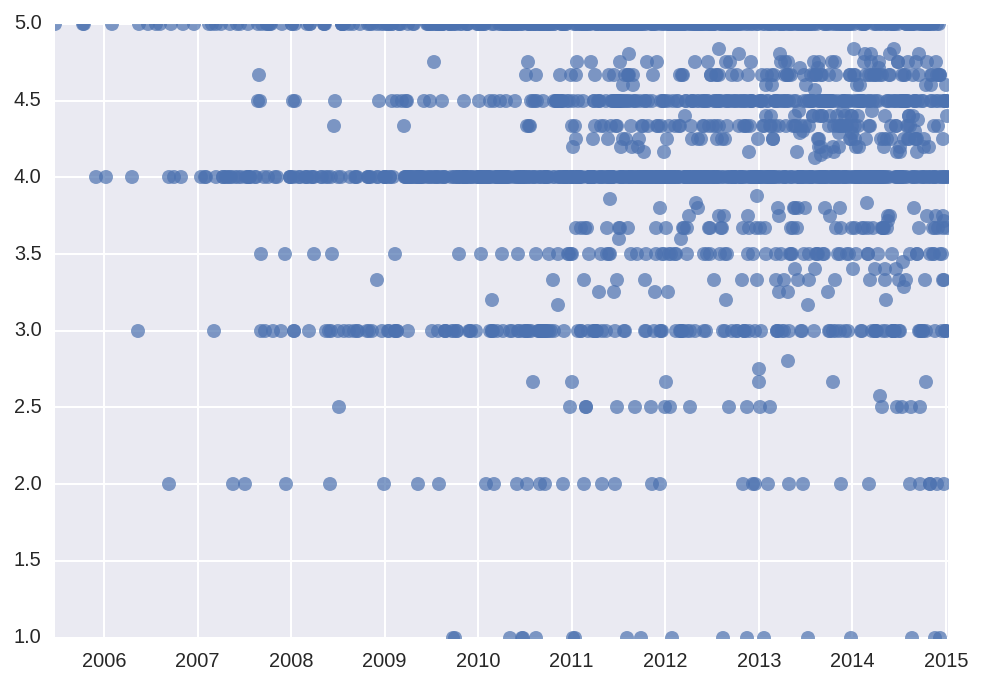

In [9]:
mag = review[review['business_id'] == '4bEjOyTaDG24SY5TxsaUNQ']
mag_avg = mag.groupby('date').mean().reset_index()
mag_avg.loc[:,'date'] = pd.to_datetime(mag_avg['date'], format='%Y-%m-%d')
plt.plot_date(mag_avg['date'],mag_avg['stars'], alpha=0.7)

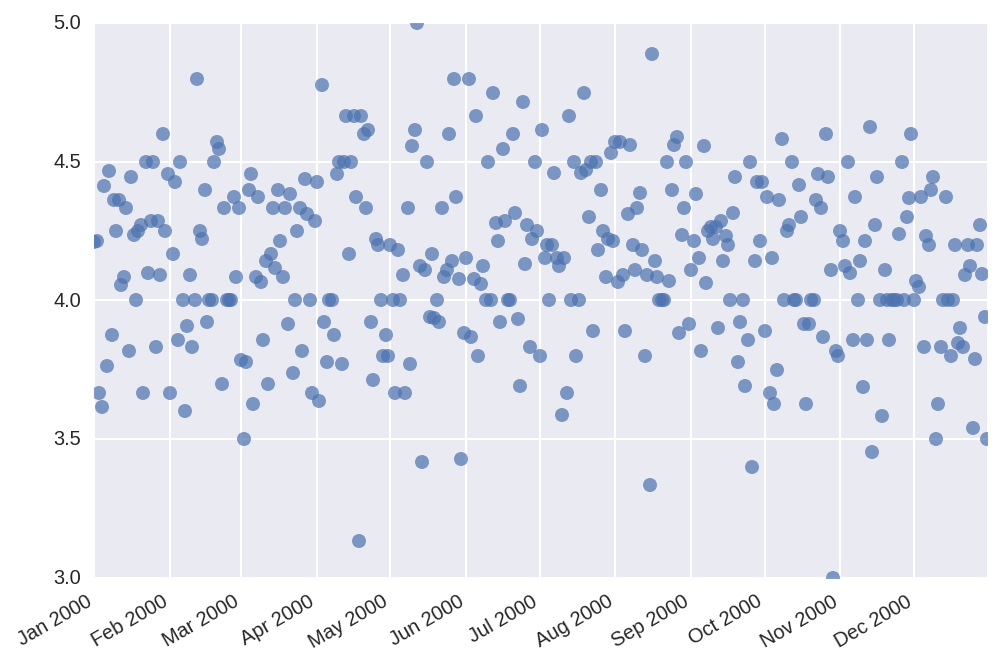

In [10]:
mag_adj_year = mag.copy()
adjust_date(mag_adj_year, year=True)
mag_avg2 = mag_adj_year.groupby('date').mean().reset_index()
plt.plot_date(mag_avg2['date'],mag_avg2['stars'], alpha=0.7)
plt.gcf().autofmt_xdate()

In [12]:
mag_adj_year = mag.copy()
adjust_date(mag_adj_year, year=True)
mag_adj_year['month'] = [t.month for t in mag_adj_year.date]
mag_avg2 = mag_adj_year.groupby('month').agg(['mean', 'std', 'count']).reset_index()
# Remove hierarchical column names
mag_avg2.columns = [' '.join(col).strip() for col in mag_avg2.columns.values]
mag_avg2

,month,votes.cool mean,votes.cool std,votes.cool count,votes.funny mean,votes.funny std,votes.funny count,stars mean,stars std,stars count,votes.useful mean,votes.useful std,votes.useful count
0,1,0.339474,1.018571,380,0.247368,0.738585,380,4.157895,1.007264,380,0.547368,1.230813,380
1,2,0.430189,1.485993,265,0.275472,1.247559,265,4.124528,0.955230,265,0.615094,1.636167,265
2,3,0.367978,1.343524,356,0.283708,1.085559,356,4.101124,0.922885,356,0.662921,1.767907,356
3,4,0.370242,1.147739,289,0.269896,1.068729,289,4.117647,1.006920,289,0.529412,1.277476,289
4,5,0.431884,1.619871,345,0.307246,1.282068,345,4.113043,0.962360,345,0.553623,1.576774,345
5,6,0.500000,2.272930,368,0.413043,2.079626,368,4.201087,0.978125,368,0.679348,2.351974,368
6,7,0.510152,1.564930,394,0.373096,1.449888,394,4.205584,0.905662,394,0.741117,1.764503,394
7,8,0.419355,1.589869,403,0.277916,1.470162,403,4.230769,0.924431,403,0.523573,1.794495,403
8,9,0.424069,2.167708,349,0.315186,2.006691,349,4.140401,0.950076,349,0.624642,2.232099,349
9,10,0.483221,1.212194,298,0.281879,0.995482,298,4.110738,0.969824,298,0.744966,1.431509,298


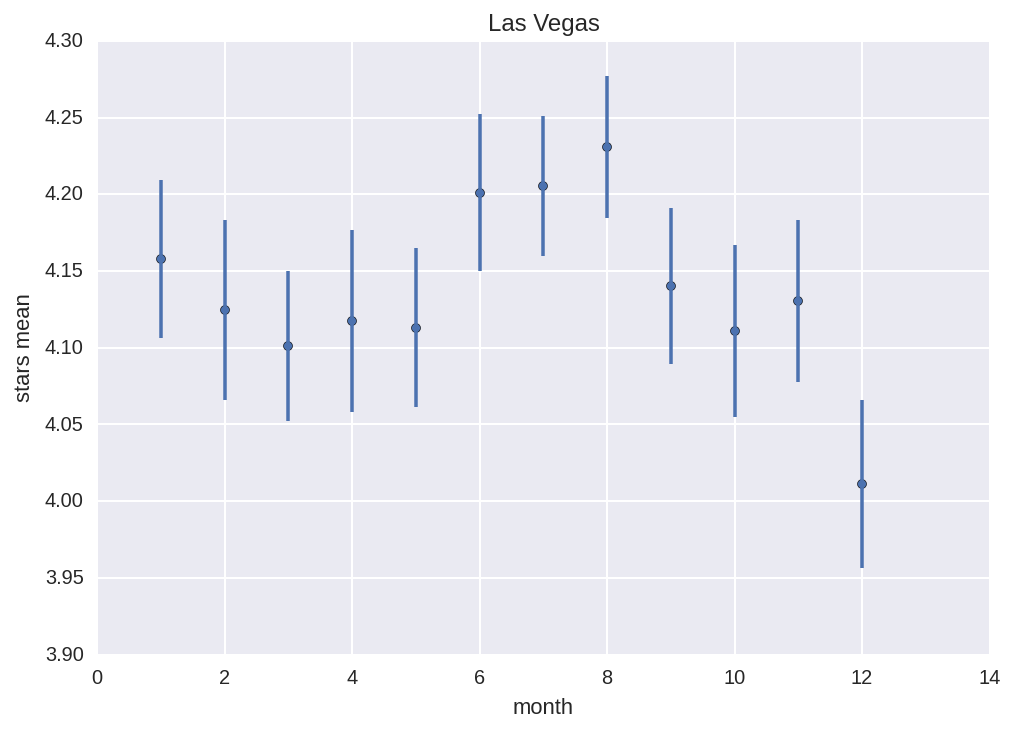

In [15]:
mag_avg2.plot(kind='scatter', x='month', y='stars mean', yerr=mag_avg2['stars std']/np.sqrt(mag_avg2['stars count']), title='Las Vegas')

#Edinburgh

In [21]:
edin_rest = restaurants[restaurants.city.isin(['Edinburgh'])]
edin_rest_ids = edin_rest.index.values
edin_rest_reviews = review[review['business_id'].isin(edin_rest_ids)]
edin_avg_review = edin_rest_reviews.groupby('business_id').agg(['mean', 'std', 'count'])
#edin_avg_review.sort_values(by=('stars', 'count'), ascending=False).head()

I need to loop over all the restaurants, but let's walk through the single restaurant here

In [22]:
edin_tmp = review[review['business_id'] == 'lYNVfn3o7tTqSAPTaBLAWA']
edin_tmp_adj_year = edin_tmp.copy()
adjust_date(edin_tmp_adj_year, year=True)
edin_tmp_adj_year['month'] = [t.month for t in edin_tmp_adj_year.date]
edin_tmp_avg2 = edin_tmp_adj_year.groupby('month').agg(['mean', 'std', 'count']).reset_index()
# Remove hierarchical column names
edin_tmp_avg2.columns = [' '.join(col).strip() for col in edin_tmp_avg2.columns.values]
edin_tmp_avg2

,month,votes.cool mean,votes.cool std,votes.cool count,votes.funny mean,votes.funny std,votes.funny count,stars mean,stars std,stars count,votes.useful mean,votes.useful std,votes.useful count
0,1,1.222222,1.092906,9,0.777778,0.833333,9,4.333333,0.866025,9,2.111111,2.088327,9
1,2,0.750000,0.462910,8,0.750000,0.886405,8,4.250000,1.035098,8,1.500000,1.069045,8
2,3,1.500000,1.643168,6,2.166667,2.136976,6,4.833333,0.408248,6,2.166667,0.983192,6
3,4,1.250000,2.005674,12,0.666667,1.073087,12,4.416667,0.900337,12,1.750000,2.378884,12
4,5,1.250000,0.500000,4,0.750000,0.500000,4,5.000000,0.000000,4,1.750000,0.500000,4
5,6,1.000000,1.154701,4,0.750000,0.957427,4,4.750000,0.500000,4,1.000000,1.414214,4
6,7,0.727273,1.009050,11,0.363636,0.674200,11,4.272727,1.103713,11,0.818182,0.873863,11
7,8,0.823529,1.131111,17,0.647059,0.931476,17,4.470588,0.624264,17,1.117647,1.218726,17
8,9,0.750000,1.215431,12,0.500000,0.674200,12,4.416667,0.900337,12,1.416667,2.108784,12
9,10,0.700000,0.948683,10,0.700000,0.674949,10,4.200000,1.032796,10,0.900000,0.994429,10


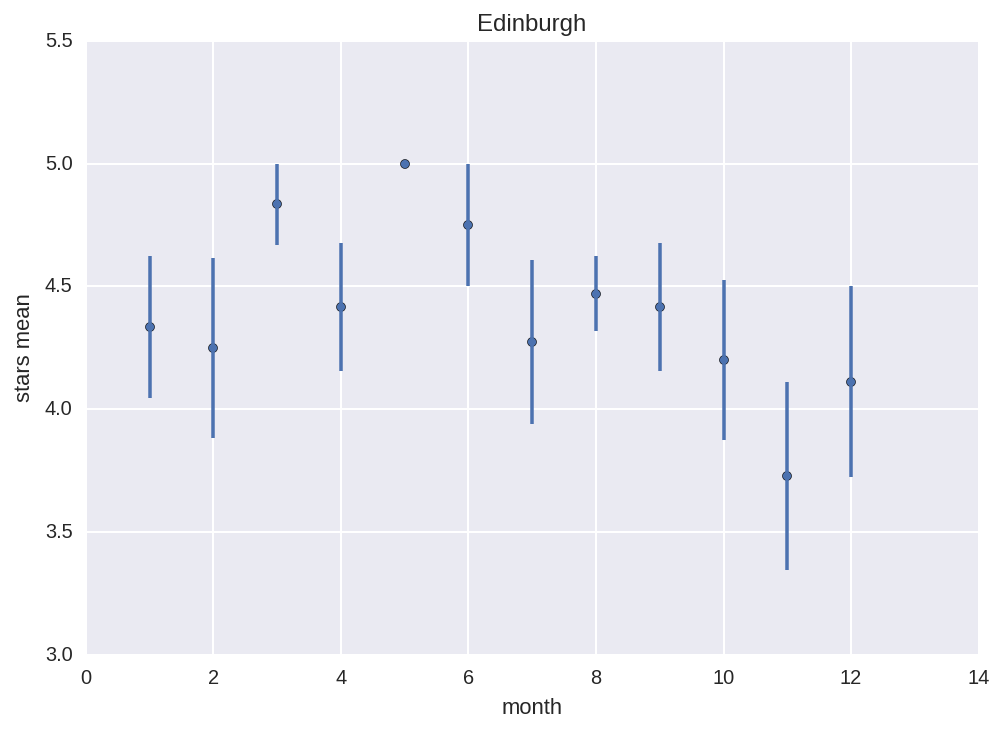

In [23]:
edin_tmp_avg2.plot(kind='scatter', x='month', y='stars mean', yerr=edin_tmp_avg2['stars std']/np.sqrt(edin_tmp_avg2['stars count']), title='Edinburgh')

# Phoenix

In [25]:
phx_rest = restaurants[restaurants.city.isin(['Phoenix'])]
phx_rest_ids = phx_rest.index.values
phx_rest_reviews = review[review['business_id'].isin(phx_rest_ids)]
phx_avg_review = phx_rest_reviews.groupby('business_id').agg(['mean', 'std', 'count'])
#phx_avg_review.sort_values(by=('stars', 'count'), ascending=False).head()

In [26]:
phx_tmp = review[review['business_id'] == 'VVeogjZya58oiTxK7qUjAQ']
phx_tmp_adj_year = phx_tmp.copy()
adjust_date(phx_tmp_adj_year, year=True)
phx_tmp_adj_year['month'] = [t.month for t in phx_tmp_adj_year.date]
phx_tmp_avg2 = phx_tmp_adj_year.groupby('month').agg(['mean', 'std', 'count']).reset_index()
# Remove hierarchical column names
phx_tmp_avg2.columns = [' '.join(col).strip() for col in phx_tmp_avg2.columns.values]
phx_tmp_avg2

,month,votes.cool mean,votes.cool std,votes.cool count,votes.funny mean,votes.funny std,votes.funny count,stars mean,stars std,stars count,votes.useful mean,votes.useful std,votes.useful count
0,1,1.366071,2.581973,112,1.241071,2.732011,112,3.919643,1.186549,112,2.044643,3.302711,112
1,2,1.117647,2.300642,102,1.098039,2.565999,102,3.725490,1.290919,102,1.754902,2.829954,102
2,3,1.135135,2.042665,111,0.891892,1.903830,111,3.783784,1.238807,111,2.018018,2.821934,111
3,4,1.200000,2.374939,120,1.125000,3.283681,120,4.025000,1.246592,120,1.866667,3.156781,120
4,5,1.930435,8.498423,115,1.434783,6.049693,115,3.895652,1.293533,115,2.652174,9.206256,115
5,6,1.346154,2.436651,104,1.000000,2.372987,104,3.961538,1.198082,104,1.836538,2.926646,104
6,7,0.541667,1.129407,120,0.433333,1.034963,120,3.850000,1.220621,120,1.025000,1.374819,120
7,8,1.125000,2.484598,128,0.570312,1.545548,128,4.039062,1.089697,128,1.570312,2.774131,128
8,9,0.724490,1.352970,98,0.632653,1.522259,98,4.000000,1.218415,98,1.204082,2.060723,98
9,10,1.048077,1.813540,104,0.750000,1.453152,104,4.000000,1.165857,104,1.423077,2.296863,104


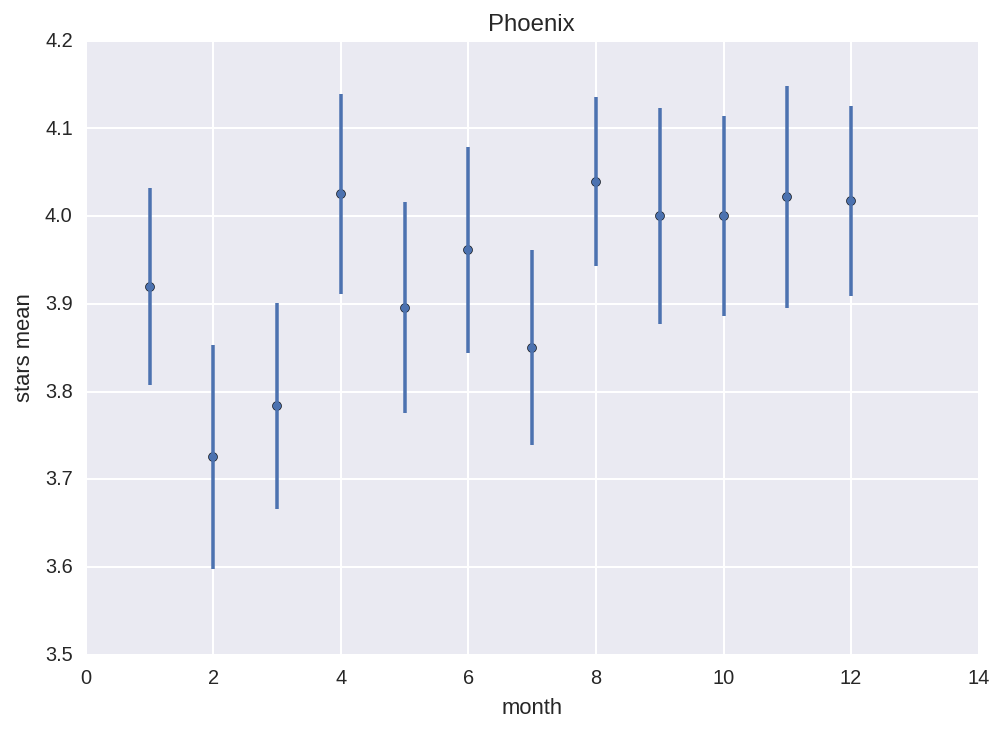

In [27]:
phx_tmp_avg2.plot(kind='scatter', x='month', y='stars mean', yerr=phx_tmp_avg2['stars std']/np.sqrt(phx_tmp_avg2['stars count']), title='Phoenix')

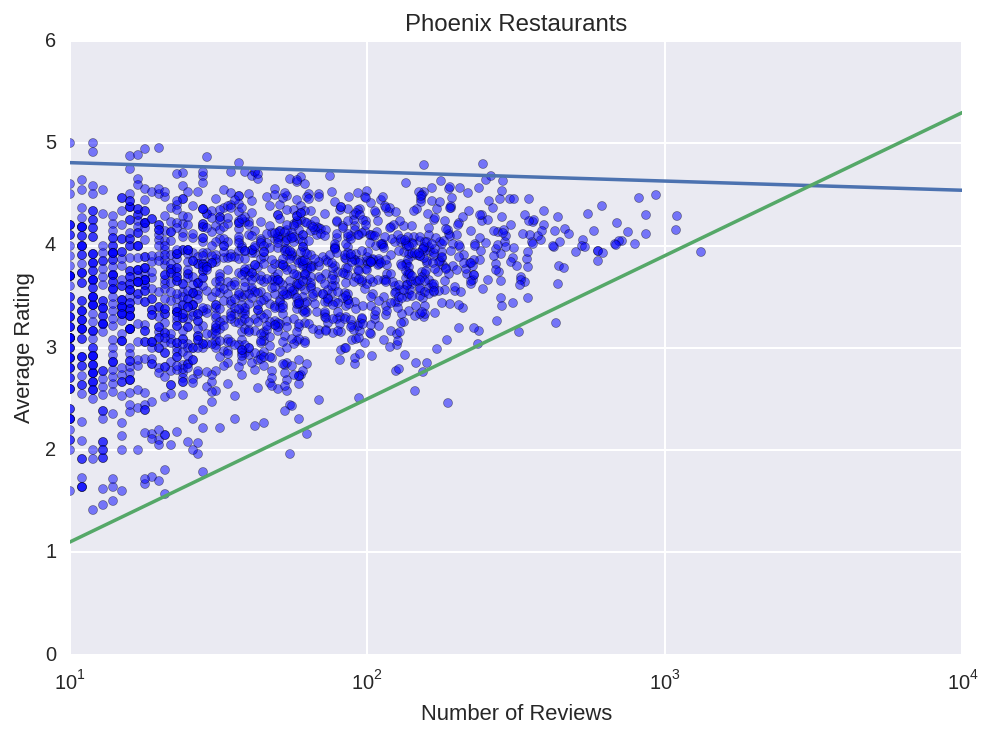

In [28]:
x = phx_avg_review['stars']['count']
y = phx_avg_review['stars']['mean']
#phx_avg_review.plot(kind='scatter',x=['stars count'],y=['stars mean'])
plt.scatter(x,y, alpha=0.5)
plt.xscale('log')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Rating')
plt.title('Phoenix Restaurants')
plt.xlim([10,10000])

# Overplot the bounding lines
x1 = 10**np.arange(1,5)
uy = -0.09*np.log10(x1)+ 4.9
ly = 1.4*np.log10(x1)-0.3

plt.plot(x1,uy)
plt.plot(x1,ly)